In [64]:
import os
import h5py
import matplotlib.pyplot as plt
import tomopy

# Path to the download folder
download_folder = '/home/ravescovi/Downloads/NSLS2/scan_00244'

# List all files in the download folder
files = os.listdir(download_folder)
print(files)

# panda = os.path.join(download_folder, 'panda.hdf')
# panda_data = h5py.File(panda, 'r').keys()
# print(panda_data)

print('main file')
main_file = os.path.join(download_folder, 'scan_00244.nxs')

proj_file = os.path.join(download_folder, 'proj_00000.hdf')
data_images = h5py.File(proj_file, 'r')['entry']['data']['data']
angles = h5py.File(main_file, 'r')['entry']['data']['rotation_angle']
##
print(data_images)
print(angles)


['proj_00000.hdf', 'panda.hdf', 'scan_00244.nxs']
<HDF5 dataset "data": shape (1801, 3200, 3200), type "<u2">
<HDF5 dataset "rotation_angle": shape (1801,), type "<f4">


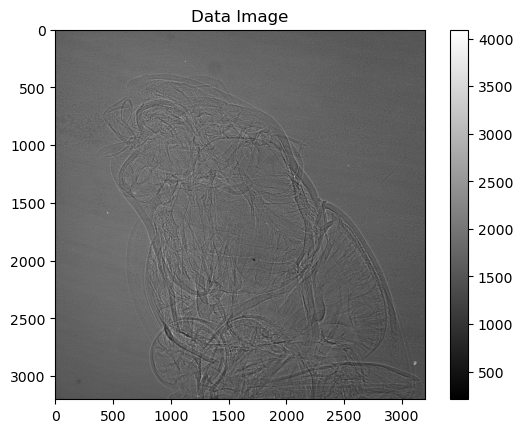

In [65]:

# Show one of the data images
plt.imshow(data_images[0,:,:], cmap='gray')
plt.title('Data Image')
plt.colorbar()
plt.show()

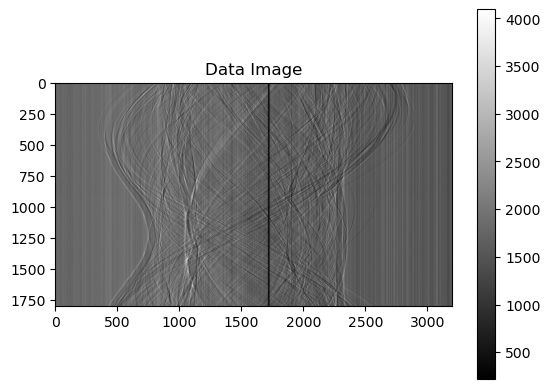

In [67]:

# Show one of the data images
plt.imshow(data_images[:,2000,:], cmap='gray')
plt.title('Data Image')
plt.colorbar()
plt.show()

In [68]:
tomo = tomopy.recon(data_images[:,1000:1100,:], angles, algorithm='gridrec')
print(tomo.shape)

(100, 3200, 3200)


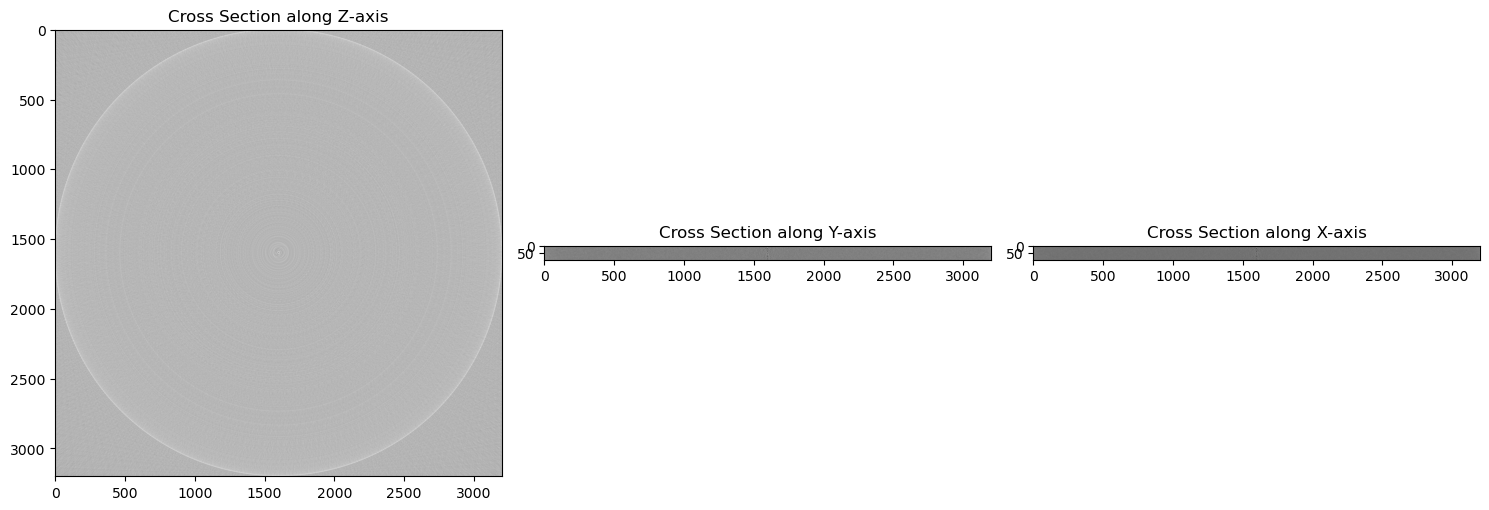

In [69]:
# Plot cross sections of tomo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the middle slice in each dimension
axes[0].imshow(tomo[tomo.shape[0] // 2, :, :], cmap='gray')
axes[0].set_title('Cross Section along Z-axis')

axes[1].imshow(tomo[:, tomo.shape[1] // 2, :], cmap='gray')
axes[1].set_title('Cross Section along Y-axis')

axes[2].imshow(tomo[:, :, tomo.shape[2] // 2], cmap='gray')
axes[2].set_title('Cross Section along X-axis')

plt.tight_layout()
plt.show()

In [63]:
import os
import h5py

# Path to the download folder
download_folder = '/home/ravescovi/Downloads/NSLS2/scan_00245'

# List all files in the download folder
files = os.listdir(download_folder)
print(files)


flat_file = os.path.join(download_folder, 'flat_00000.hdf')
dark_file = os.path.join(download_folder, 'dark_00000.hdf')
data_file = os.path.join(download_folder, 'scan_00245.nxs')

print("Flat file path:", flat_file)
print("Dark file path:", dark_file)
print("Data files paths:", data_file)

flat_images = h5py.File(flat_file, 'r')['entry']['data']['data']
dark_images = h5py.File(dark_file, 'r')['entry']['data']['data']
data_images = h5py.File(data_file, 'r')['entry']['data'].keys()

print(flat_images)
print(dark_images)
print(data_images)


['flat_00000.hdf', 'dark_00000.hdf', 'scan_00245.nxs']
Flat file path: /home/ravescovi/Downloads/NSLS2/scan_00245/flat_00000.hdf
Dark file path: /home/ravescovi/Downloads/NSLS2/scan_00245/dark_00000.hdf
Data files paths: /home/ravescovi/Downloads/NSLS2/scan_00245/scan_00245.nxs
<HDF5 dataset "data": shape (50, 3200, 3200), type "<u2">
<HDF5 dataset "data": shape (20, 3200, 3200), type "<u2">
<KeysViewHDF5 ['dark', 'flat']>


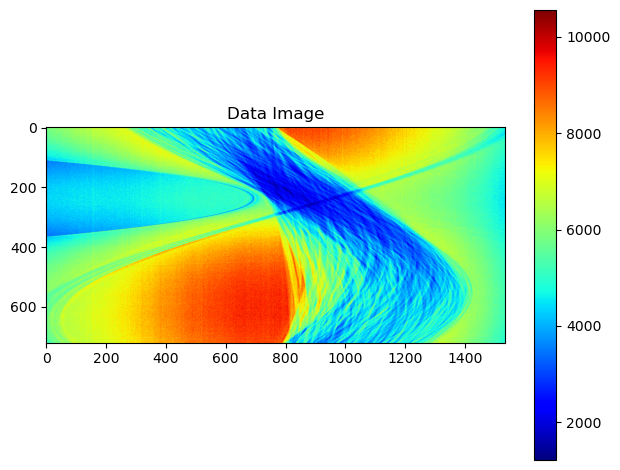

In [ ]:
import matplotlib.pyplot as plt

# Plot data image
plt.imshow(data[:,0,:], cmap='jet')
plt.title('Data Image')
plt.colorbar()

plt.tight_layout()